[gluon](http://zh.gluon.ai/chapter_computer-vision/ssd.html)   [gluon](http://zh.gluon.ai/chapter_computer-vision/anchor.html)    
这是一个没有预训练模型的SSD实现，也是因为没有预训练模型，只能用来处理一些比较简单的数据集。     

如下是SSD的框架示意图   
![SSD](images/ssd.svg)   

输入图像经过一个backbone网络提取特征，然后进行若干次下采样，每个下采样层都附带一个边框预测和类别预测模块。注意和YOLOv3不同，SSD是基于backbone的输出特征图做多次下采样，这也导致SSD对小目标检测效果不好。    


In [1]:
from mxnet import contrib, image, nd,gluon,autograd, init
from mxnet.gluon import loss as gloss, nn
import mxnet as mx


In [27]:
num_classes = 2 #类别数目

max_obj_per_image = 3 #每幅图中目标个数最大值
obj_scales = [0.3,0.4]  #目标尺寸 wrt image 关系到anchor size的选择

batch_size = 32

# 自动生成一个简单的集合

In [28]:
from PIL import Image
import numpy as np
import random
import copy,os
from mxnet.gluon import data as gdata

img_background = Image.open('images/background.jpg')
img_sprit_1 = Image.open('images/sprits_1.jpg')
img_sprit_2 = Image.open('images/sprits_2.jpg')




outdir = 'data/temp'
if not os.path.exists(outdir):
    os.makedirs(outdir)

def paste_it(background, sprit, mask):
    W,H = background.size
    W1,H1 = sprit.size
    s1 = random.randint(0,len(obj_scales) - 1)
    x1,y1,s1 = random.randint(10,W-10), random.randint(10,H-10), obj_scales[s1] * W / W1
    s1 = sprit.resize( (int(W1*s1), int(H1*s1)), Image.BILINEAR )
    if random.randint(0,2) == 0:
        s1 = s1.transpose(Image.FLIP_LEFT_RIGHT)
    x2,y2 = x1 + s1.size[0], y1 + s1.size[1]
    if x2 >= W or y2 >= H:
        return background,None
    if mask[y1:y2, x1:x2].sum() > 10:
        return background,None
    mask[y1:y2,x1:x2] = 1
    result = copy.deepcopy(background)
    result.paste(s1,(x1,y1,x2,y2))
    return result,(x1/W,y1/H,x2/W,y2/H)
    
W,H = img_background.size

Xs, Ys = [], []
total_image = 1024
for num in range(total_image):
    mask = np.zeros((H,W))
    img_compose = copy.deepcopy(img_background)
    Y = []
    for k in range(max_obj_per_image):
        rnd = random.randint(0,2) 
        if rnd == 0:
            img_compose,sprit_1 = paste_it(img_compose,img_sprit_1,mask)
            if sprit_1 is not None:
                Y.append( (0,) + sprit_1  )
        else:
            img_compose,sprit_2 = paste_it(img_compose,img_sprit_2,mask)
            if sprit_2 is not None:
                Y.append( (1,) + sprit_2  )
                
    if len(Y) < 1:
        continue #skip image without object
    Ys.append(Y)                
    
    outpath = os.path.join(outdir,"%d.jpg"%num)
    Xs.append(outpath)
    img_compose.save(outpath)


    
class ToySet(gdata.Dataset):
    def __init__(self,fortrain,path_list, label_list):
        super(ToySet,self).__init__()
        self.data_list = []
        self.fortrain = fortrain
        self.resize = (256,256)
        self.max_obj_per_image = max_obj_per_image
        for path, labels in zip(path_list, label_list):
            if len(labels) < 1:
                continue
            self.data_list.append((path,labels))
        return
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        path = self.data_list[idx][0]
        labels = self.data_list[idx][1]
        img = Image.open(path)
        img = img.resize(self.resize, Image.BILINEAR)
        img = np.array(img)             
        H,W,_ = img.shape
        
        if 0:
            bbox = labels[0][1:5]
            print(bbox * np.array([W,H,W,H]))
            fig = plt.imshow(img)
            rect = plt.Rectangle(xy=(bbox[0]*W, bbox[1]*H), width=bbox[2]*W-bbox[0]*W,
                             height=bbox[3]*H-bbox[1]*H, fill=False, edgecolor='r',linewidth=2)

            fig.axes.add_patch(rect)
        
        
        img = np.transpose(img,(2,1,0)).astype(np.float32)
        img = nd.array(img)
        if len(labels) < self.max_obj_per_image: #label的第二个维度表示训练集中每个图中最大目标个数
            for k in range(self.max_obj_per_image - len(labels)):
                labels.append([-1,-1,-1,-1,-1])
        labels = np.vstack(labels)                
        labels = nd.array(labels)
        return img,labels
    
trainset = ToySet(True,Xs,Ys)
train_iter = gdata.DataLoader(trainset,batch_size,shuffle=True,last_batch="rollover")

#for X,Y in train_iter:
#    print(X.shape, Y.shape)
    #print(Y)
    #break

# 自定义一个简单的Backbone网络

In [29]:

#这个下采样层既用在backbone中，也用在后续的检测模块中
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

#backbone
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

#完整的特征提取模块
#0： backbone
#1,2,3： 三个下采样层
#4：一个global max pool层
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk






# 定义类别预测层和边框预测层

In [30]:
#类别预测层，这里用一个卷积层实现
#其输入输出层的w/h必须一致
#输出通道数C等于(anchor个数)x(类别数+1)，这里类别不包括背景，+1就是背景类
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)


#边框预测层，也用一个卷积层实现
#输入输出的w/h必须一致
#输出通道数C等于4x(anchor个数)
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)


#不同层预测出来的类别和边框的尺寸是不一样的，下面定义了一种合并方式
#每一层输出的是shape是(batch,C,H,W),不同层的输出，只有batch是一致的，其他三个值都不一样
#下面的函数把(batch,C,H,W)转换成(batch,HxWxC)
#最后在dim=1上连接
#注意mx.nd.flatten()的功能和numpy.flatten()不同，mx.nd.flatten()会保留维度0，只合并后面的维度
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

# 定义每个层如何预测 (SSD的重点）

In [31]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) #提取特征
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio) #获得anchor
    cls_preds = cls_predictor(Y) #预测类别 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    bbox_preds = bbox_predictor(Y) #预测边界框 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    return (Y, anchors, cls_preds, bbox_preds)

# 定义SSD模型

In [37]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        
        #self.sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],[0.88, 0.961]]
        #self.ratios = [[1, 2, 0.5]] * 5
        self.sizes = [[0.15, 0.2], [0.25, 0.3], [0.35,0.4], [0.3, 0.4],[0.3, 0.4]]
        self.ratios = [[1, 2, 0.5]] * 5
        self.num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        self.stage_0, self.stage_1, self.stage_2, self.stage_3, self.stage_4 = nn.Sequential(),nn.Sequential(),nn.Sequential(),nn.Sequential(),nn.Sequential()
        
        self.stage_0.add(get_blk(0), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #backbone
        self.stage_1.add(get_blk(1), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第1个预测层
        self.stage_2.add(get_blk(2), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第2个预测层
        self.stage_3.add(get_blk(3), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第3个预测层
        self.stage_4.add(get_blk(4), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第4个预测层 
        return
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        X,anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.stage_0[0], self.sizes[0], self.ratios[0], self.stage_0[1], self.stage_0[2])
        X,anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.stage_1[0], self.sizes[1], self.ratios[1], self.stage_1[1], self.stage_1[2])
        X,anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.stage_2[0], self.sizes[2], self.ratios[2], self.stage_2[1], self.stage_2[2])
        X,anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.stage_3[0], self.sizes[3], self.ratios[3], self.stage_3[1], self.stage_3[2])
        X,anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.stage_4[0], self.sizes[4], self.ratios[4], self.stage_4[1], self.stage_4[2])
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                    (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))
    
    
    
net = TinySSD(num_classes=num_classes)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 3)
output bbox preds: (32, 21776)


# 定义loss和metrics

In [38]:
import pdb
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox



def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
   # print (bbox_labels*bbox_masks)
  #  print (bbox_preds*bbox_masks).sum()
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()



# 训练

In [39]:
import time
from mxnet import lr_scheduler
ctx, net = mx.gpu(), TinySSD(num_classes=num_classes)
net.initialize(init=init.Xavier(), ctx=ctx)


num_epochs = 50
lr_sch = lr_scheduler.FactorScheduler(step=500, factor=0.1)
lr_sch.base_lr = 1.0/2
    
trainer = gluon.Trainer(net.collect_params(), 'sgd',{'wd': 5e-4})


start = time.time()
for epoch in range(num_epochs):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    loss_hist = []
    trainer.set_learning_rate(lr_sch(epoch))
    for batch in train_iter:        
        X = batch[0].as_in_context(ctx)
        Y = batch[1].as_in_context(ctx)
        #print(X.shape,Y.shape)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            #print(cls_preds.transpose((0, 2, 1)).shape)
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        nd.waitall()
        loss_hist.append( l.asnumpy()[0] / batch_size )
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size


    if (epoch + 1) % 10 == 0:
        loss = np.asarray(loss_hist).mean()
        print('epoch %2d, class err %.5e, bbox mae %.5e, loss %.5e, lr %.5e time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, loss, trainer.learning_rate, time.time() - start))
        start = time.time() #restart

epoch 10, class err 4.62952e-03, bbox mae 3.98878e-03, loss 7.09368e-04, lr 5.00000e-01 time 56.6 sec
epoch 20, class err 4.53290e-03, bbox mae 3.69599e-03, loss 6.88546e-04, lr 5.00000e-01 time 56.5 sec
epoch 30, class err 4.47103e-03, bbox mae 3.56937e-03, loss 6.99015e-04, lr 5.00000e-01 time 56.6 sec
epoch 40, class err 4.35973e-03, bbox mae 3.43656e-03, loss 5.77626e-04, lr 5.00000e-01 time 56.7 sec
epoch 50, class err 4.24269e-03, bbox mae 3.31464e-03, loss 6.74142e-04, lr 5.00000e-01 time 56.9 sec


# 预测

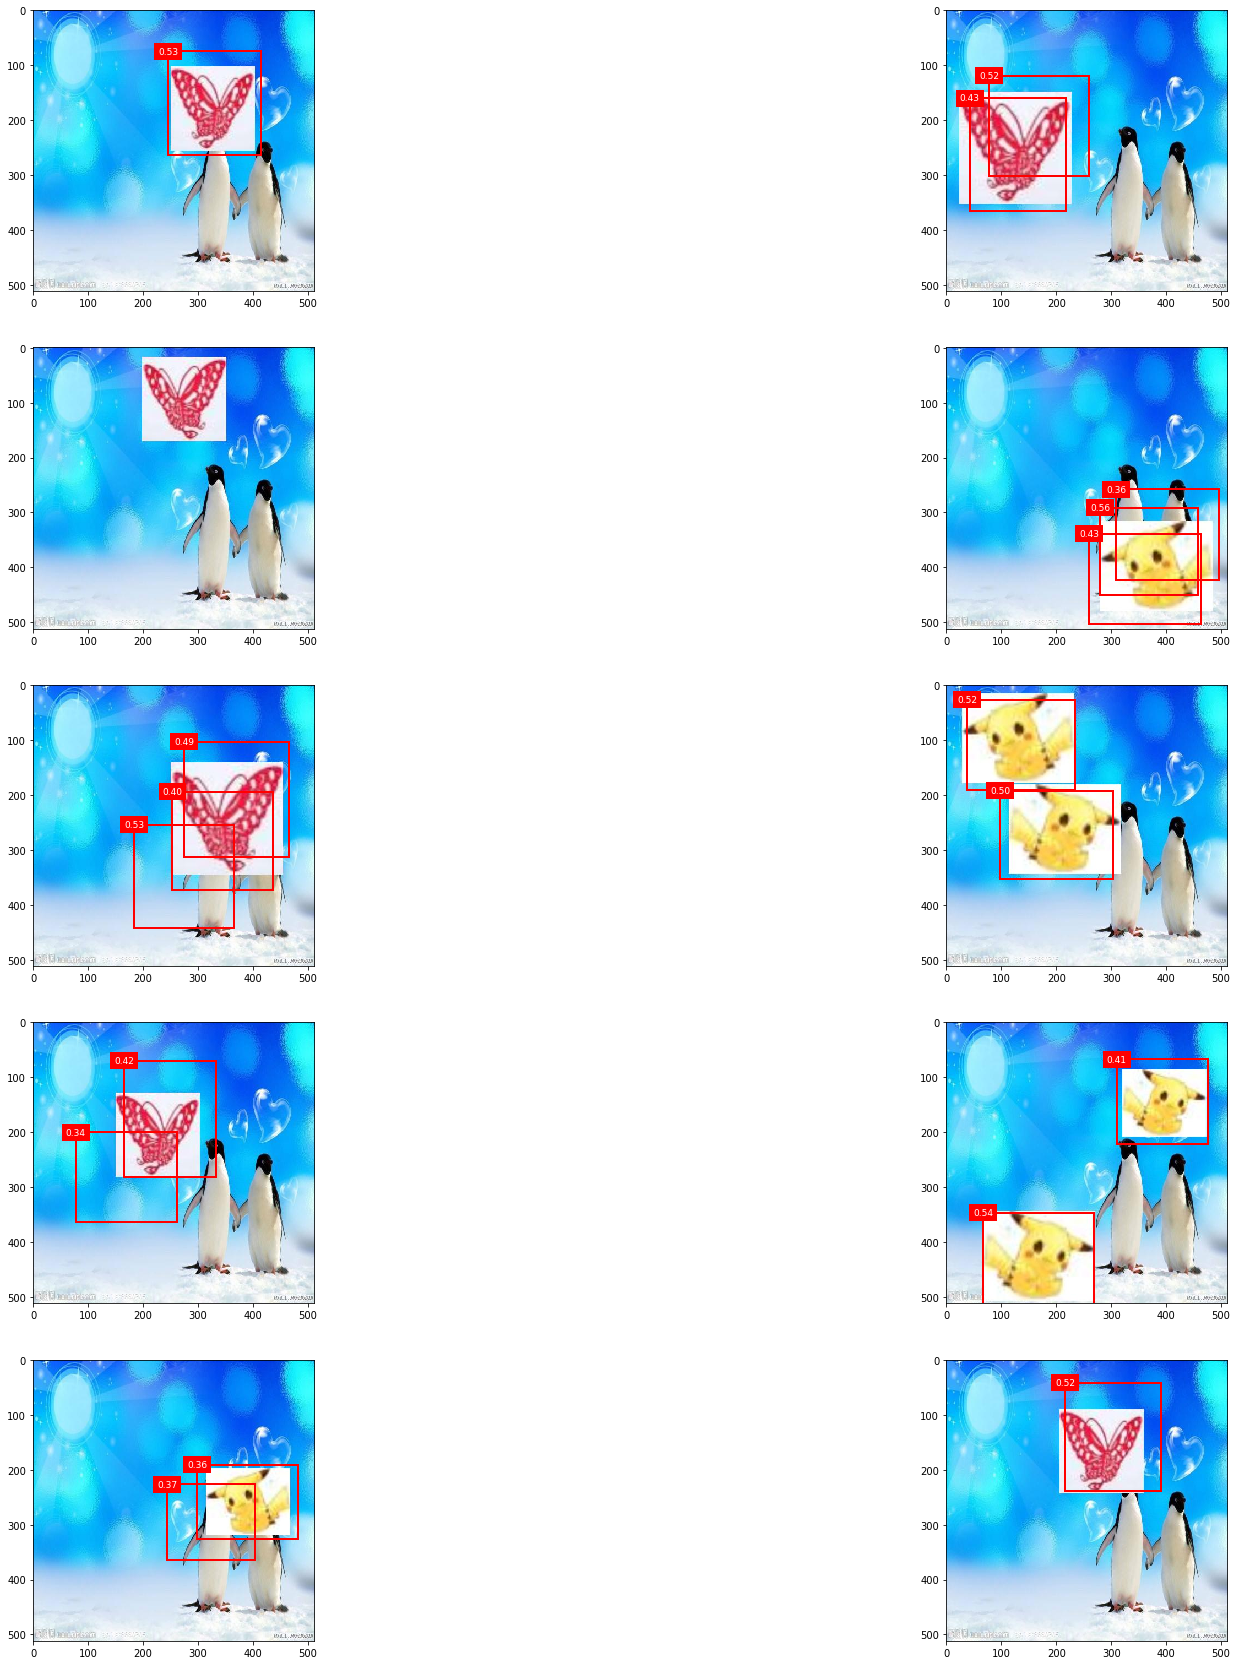

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    #print(bbox_preds)
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    if len(idx) < 1:
        return None
    return output[0, idx]

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
                         height=bbox[3]-bbox[1], fill=False, edgecolor=color,linewidth=2)

def _make_list(obj, default_values=None):
    if obj is None:
        obj = default_values
    elif not isinstance(obj, (list, tuple)):
        obj = [obj]
    return obj

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'k'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,bbox=dict(facecolor=color, lw=0))

def display(fig,img, output, threshold):
    fig.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            #print('skip obj with low score:',row)
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        #print(bbox)
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')


plt.figure(figsize=(30,30))
for ind in range(0,10):
    fig = plt.subplot(5,2,ind+1)
    if isinstance(train_iter, mx.image.ImageDetIter):
        img = image.imread('data/pikachu/pikachu.jpg')
    else:
        img = image.imread(Xs[ind*5])
    feature = image.imresize(img, 256, 256).astype('float32') / 1.0
    X = feature.transpose((2, 0, 1)).expand_dims(axis=0)        

    output = predict(X)



    if output is not None:
        display(fig,img, output, threshold=0.3)
    else:
        print('no-obj found')